## Proxy voting

<a id="section_facts_dummy"></a>
A large percentage of the equities market is managed passively (up to 40% according to a [report by Bank of America](https://www.reuters.com/article/us-stocks-etf-research-idUSKBN19Q18B)). As we've discussed in [other](https://www.matter-funds.com/a-new-kind-of-investing/) [places](https://www.matter-funds.com/engaging-is-better-than-avoiding/), this raises concerns about the effectiveness of corporate governance in the modern world.

Passive index funds are incentivised to:
1. track the performance of their benchmark (e.g. S&P 500)
1. do it as cheaply as possible.

Those two incentives means there is little reason for passive funds to engage and disagree with management on any issue: engagement requires costly research, time, and effort and it doesn't make the index fund track the benchmark any more closely.

It is easier for passive index funds to follow management or third-party voting recommendations, with the result being a world where the balance of power is tipped excessively towards corporate managers.

To gain a better understanding of the phenomenon, we look at historical voting data from top passive index providers:
1. Vanguard
1. Blackrock
1. State Street

For the impatient reader, we see the following stylised facts:
<a id="section_facts"></a>
1. Mutual funds follow management recommendations an overwhelmingly large number of times. On average, these funds vote according to management around 95% of the time. Moreover, the trend for State Street and Vanguard, in particular, has been towards even more agreement. ([details](#section_agreement))
1. When it comes to compensation, mutual funds very rarely vote against management: on average, less than 4% of the time. ([details](#section_compensation))

## The data

In the US, mutual funds are legally required to:
1. cast all their proxy votes
2. disclose their voting via a [form N-PX](https://www.sec.gov/edgar/searchedgar/n-px.htm).

An example of what the [raw N-PX data](https://www.sec.gov/Archives/edgar/data/1094885/000119312518263427/0001193125-18-263427.txt) looks like:
```
APPLE INC.

Ticker:       AAPL           Security ID:  037833100
Meeting Date: FEB 13, 2018   Meeting Type: Annual
Record Date:  DEC 15, 2017

#   Proposal                             Mgt Rec Vote Cast Sponsor
1a  Elect Director James Bell            For     For       Management
1b  Elect Director Tim Cook              For     For       Management
1c  Elect Director Al Gore               For     For       Management
1d  Elect Director Bob Iger              For     For       Management
1e  Elect Director Andrea Jung           For     For       Management
1f  Elect Director Art Levinson          For     For       Management
1g  Elect Director Ron Sugar             For     For       Management
1h  Elect Director Sue Wagner            For     For       Management
2   Ratify Ernst & Young LLP as Auditors For     For       Management
3   Advisory Vote to Ratify Named        For     For       Management
    Executive Officers' Compensation
4   Amend Non-Employee Director Omnibus  For     For       Management
    Stock Plan
5   Proxy Access Amendments              Against Against   Shareholder
6   Establish Human Rights Committee     Against Against   Shareholder
```

The above shows how [State Street Equity 500](https://money.usnews.com/funds/mutual-funds/large-blend/state-street-equity-500-index-fund/stfax) - a large S&P 500 tracking fund - voted in the Apple Annual General Meeting.
The data is quite rich - we can see:
1. The name of each proposal
1. How management recommends their shareholders vote
1. How State Street voted
1. Who is sponsoring the proposal.

### Parsed data
As part of our research work at Matter, we collect, clean and parse mutual fund voting data. You can see the codebase used to generate the mutual fund proxy voting data [here](https://github.com/matter-funds/npx_forms).

Each fund has a different format for their form N-PX, so we have to do a bit of work to normalise and join the data together.

If you want to see the nitty gritty code details, use this button to display the code used for this analysis.
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show all code"></form>

In [31]:
from pathlib import Path
import pandas as pd
npx_parsed_path = Path("/home/bogdan/projects/proxymonitor/data/npx_forms_parsed/STATE_STREET_MASTER_FUNDS")
npx_files = list(npx_parsed_path.glob("*/State_Street_Equity_500_Index_Portfolio.csv"))
ps = [pd.read_csv(f) for f in npx_files]
for df,file in zip(ps, npx_files):
    token = str(file).split('-')[1]
    df['VoteId'] = df['VoteId'].astype(str) + '_' + token
ps_stt = pd.concat(ps, ignore_index=True)
ps_stt['Fund'] = 'State Street'

In [32]:
common_columns = ['VoteId','Proposal','Sponsor','VoteCast','Name','Ticker','Num','NumRoot','Fund','Agree','ReportYear']

In [33]:
#Drop badly parsed rows:
ps_stt = ps_stt[~ps_stt["NumType"].isnull()]
ps_stt = ps_stt[~ps_stt["Num"].isnull()]
ps_stt['MeetDate'] = pd.to_datetime(ps_stt['MeetDate'])
adj_term = ps_stt['MeetDate'].min() - pd.to_datetime('2014.01.01')
ps_stt['ReportYear'] = (ps_stt['MeetDate'] - adj_term).dt.year + 1

ps_stt['Agree'] = ps_stt['MgtRec']==ps_stt['VoteCast']
ps_stt = ps_stt[common_columns]

In [34]:
npx_parsed_path = Path("/home/bogdan/projects/proxymonitor/data/npx_forms_parsed/iShares_Trust")
npx_files = list(npx_parsed_path.glob("*/iShares_Core_S&P_500_ETF.csv"))
ps = [pd.read_csv(f) for f in npx_files]
for df,file in zip(ps, npx_files):
    token = '_'.join(str(file).split('/')[-2].split('-')[1:][::-1])
    df['VoteId'] = df['VoteId'].astype(str) + '_' + token
ps_br = pd.concat(ps, ignore_index=True)
ps_br['Fund'] = 'Blackrock'

In [35]:
#Drop badly parsed rows:
ps_br = ps_br[~ps_br["NumType"].isnull()]
ps_br = ps_br[~ps_br["Num"].isnull()]
ps_br['MeetDate'] = pd.to_datetime(ps_br['MeetDate'])
adj_term = ps_br['MeetDate'].min() - pd.to_datetime('2012.01.01')
ps_br['ReportYear'] = (ps_br['MeetDate'] - adj_term).dt.year + 1

ps_br['Agree'] = ps_br['MgtRec']==ps_br['VoteCast']
ps_br = ps_br[common_columns]

In [36]:
npx_parsed_path = Path("/home/bogdan/projects/proxymonitor/data/npx_forms_parsed/VANGUARD/")
npx_files = list(npx_parsed_path.glob("*"))
ps = [pd.read_csv(f, index_col=0) for f in npx_files]
for df,file in zip(ps, npx_files):
    token = str(file)[-8:]
    df['VoteId'] = df['VoteId'].astype(str) + '_' + token
ps_vg = pd.concat(ps, ignore_index=True)
ps_vg['Fund'] = 'Vanguard'

In [37]:
ps_vg['MeetDate'] = pd.to_datetime(ps_vg['MeetDate'])
adj_term = ps_vg['MeetDate'].min() - pd.to_datetime('2011.01.01')
ps_vg['ReportYear'] = (ps_vg['MeetDate'] - adj_term).dt.year + 1

ps_vg['Agree'] = ps_vg['ForAgainstMgmt'].apply(lambda x:{'FOR':True,'AGAINST':False}.get(x,'N/A'))
ps_vg['MgtRec'] = 'N/A'
ps_vg.loc[ps_vg['Agree']==True,'MgtRec'] = ps_vg['VoteCast']
ps_vg.loc[ps_vg['Agree']==False,'MgtRec'] = ps_vg['VoteCast'].apply(lambda x:{'FOR':'AGAINST','AGAINST':'FOR'}.get(x,'N/A'))
ps_vg = ps_vg[common_columns]

In [38]:
ps = pd.concat([ps_stt,ps_br,ps_vg], ignore_index=True)

Let's look at the data:

In [39]:
from IPython.display import display, HTML
display(HTML(ps.head(5).to_html(index=False)))

VoteId,Proposal,Sponsor,VoteCast,Name,Ticker,Num,NumRoot,Fund,Agree,ReportYear
VoteId0_18,Elect Director Sondra L. Barbour,Management,For,3M COMPANY,MMM,1a,1,State Street,True,2018
VoteId0_18,Elect Director Thomas 'Tony' K. Brown,Management,For,3M COMPANY,MMM,1b,1,State Street,True,2018
VoteId0_18,Elect Director David B. Dillon,Management,For,3M COMPANY,MMM,1c,1,State Street,True,2018
VoteId0_18,Elect Director Michael L. Eskew,Management,For,3M COMPANY,MMM,1d,1,State Street,True,2018
VoteId0_18,Elect Director Herbert L. Henkel,Management,For,3M COMPANY,MMM,1e,1,State Street,True,2018


We get one row per proposal with some metadata added for convenience. We preserve all the data from the original N-PX documents, such as cast votes and management recommendations.

Let's now look at the coverage.

In [40]:
pt = ps.groupby(by=['ReportYear','Fund'])['VoteId'].agg(lambda x:len(x.unique())).reset_index(name='Vote Count')
pt = pt.pivot_table(index='ReportYear', columns='Fund', values='Vote Count')
pt = pt.astype('Int64')
display(HTML(pt.to_html()))

Fund,Blackrock,State Street,Vanguard
ReportYear,,,
2012,NaN,NaN,503
2013,515,NaN,517
2014,510,NaN,510
2015,521,522,526
2016,530,528,537
2017,518,518,530
2018,510,512,516


As expected, we have almost 500 annual meetings each year (500 index members), and around 30 special meetings each year. Special meetings are organised ad-hoc for important timely matters, such as mergers, acquisitions and other irregular but important corporate business.

We have different coverage for each fund - for the purpose of this analysis, we will only be looking at data starting Reporting Year 2015.

## A matter of form?
<a id="section_agreement"></a>
[<div style="float: right; padding-left:10px;">Go to stylised facts</div>](#section_facts)
The N-PX reports helpfully include both the vote cast by the fund as well as the management voting recommendation. So let's take a look at how often our mutual funds voted in line with management's recommendation.

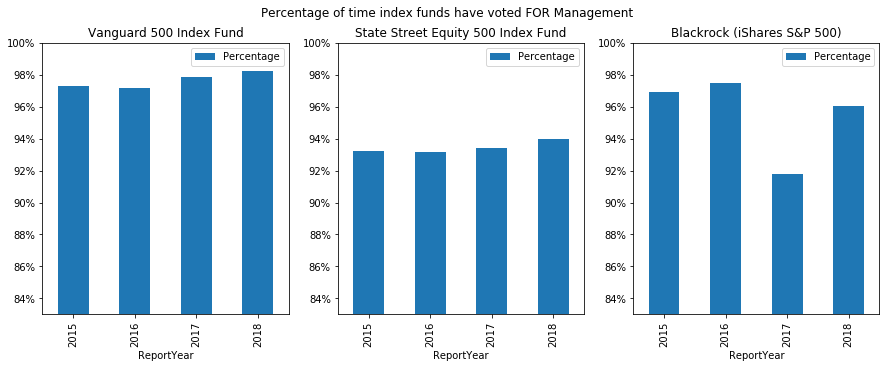

Raw data:


In [41]:
import matplotlib.pyplot as plt
pt = ps.copy()
pt = pt.groupby(by=['Agree','VoteCast','ReportYear','Fund']).size().reset_index(name='Count').sort_values('Count', ascending=False)
pt = pt.groupby(by=['Agree','ReportYear','Fund']).agg({'Count':sum}).reset_index()
pt['Percentage'] = pt.groupby(by=['ReportYear','Fund'])['Count'].transform(lambda x:x/sum(x))
pt = pt[pt['Agree']==True].drop('Agree', axis=1)
pt = pt[pt['ReportYear']>=2015]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
pt[pt['Fund']=='Vanguard'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0.83,1), kind='bar',
                                title='Vanguard 500 Index Fund',
                                ax=axes[0])
pt[pt['Fund']=='State Street'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0.83,1), kind='bar',
                                title='State Street Equity 500 Index Fund',
                                ax=axes[1])
pt[pt['Fund']=='Blackrock'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0.83,1), kind='bar',
                                title='Blackrock (iShares S&P 500)',
                                ax=axes[2])
fig.suptitle('Percentage of time index funds have voted FOR Management')
for ax in axes:
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.show()
pt = pt.pivot_table(index='ReportYear', columns='Fund', values=['Count','Percentage'])
pt['Count'] = pt['Count'].astype('Int64')
print('Raw data:')
s = pt.mean()
s.name = 'Yearly average'
display(HTML(pt.append(s).to_html(formatters= 3*['{}'.format]+3*['{:,.1%}'.format])));

Two interesting points to note here:

1. The average level of agreement is around 95%. The absolute level of agreement, of course, only tells part of the story but it does paint a picture of mutual funds who are broadly content with the status quo.
1. There are differences in how much different passive funds agree with management - Vanguard, in particular, followed management recommendations a whopping 98.3% of the time in the year reported 2018.
1. The agreement ratio has been trending upwards in recent years (for Vanguard and State Street), so this fund-management dynamic has been increasing in strength.


## Show me the money
One big voting topic is corporate compensation, e.g.:
1. how much should the CEO be paid?
1. how much of that should be cash and how much in stock?
1. what should the compensation be dependent on? Stock price, revenue, CO2 emissions?

First, how often is compensation voted on?

In [42]:
ps['Comp related'] = ps['Proposal'].str.contains('compensation', case=False)

In [43]:
pt = ps[ps['Fund']=='Vanguard']
ptcr = pt[pt['Comp related']]
ptcr = ptcr.groupby(by=['ReportYear'])['VoteId'].agg(lambda x:len(x.unique())).reset_index(name='Meetings w/ comp votes')
pt = pt.groupby(by=['ReportYear'])['VoteId'].agg(lambda x:len(x.unique())).reset_index(name='Total meetings')
ptcr['Total meetings'] = pt['Total meetings']
ptcr['Perc meetings w/ comp votes'] = ptcr['Meetings w/ comp votes']/ptcr['Total meetings']
display(HTML(ptcr.to_html(formatters= {'Perc meetings w/ comp votes':'{:,.1%}'.format}, index=False)))

ReportYear,Meetings w/ comp votes,Total meetings,Perc meetings w/ comp votes
2012,460,503,91.5%
2013,467,517,90.3%
2014,486,510,95.3%
2015,465,526,88.4%
2016,465,537,86.6%
2017,501,530,94.5%
2018,477,516,92.4%


The yearly numbers vary, but, on average, 90% of the shareholder meetings have at least 1 vote related to compensation. It's a very common voting topic.

In fact, after directorship elections, compensation votes are the most common votes, as seen below:

In [44]:
#collapse the more common proposals around electing new directors and auditors.
ps['Proposal_generic'] = ps['Proposal'].copy()
ps.loc[ps['Proposal_generic'].str.match('^Elect Director ', case=False), 'Proposal_generic'] = 'Elect Director <Name>'
ps.loc[ps['Proposal_generic'].str.match('^Ratify .* as Auditors$', case=False), 'Proposal_generic'] = 'Ratify <Name> as Auditors'

In [45]:
ps[ps['Fund']=='Vanguard']['Proposal_generic'].value_counts().to_frame().head(5)

,Proposal_generic
Elect Director <Name>,32123
ADVISORY VOTE TO RATIFY NAMED EXECUTIVE OFFICERS' COMPENSATION,3320
Ratify <Name> as Auditors,1835
RATIFY AUDITORS,1481
AMEND OMNIBUS STOCK PLAN,592


<a id="section_compensation"></a>
[<div style="float: right; padding-left:10px;">Go to stylised facts</div>](#section_facts)
So given how often compensation is voted on, how often do mutual funds disagree with management on this topic?

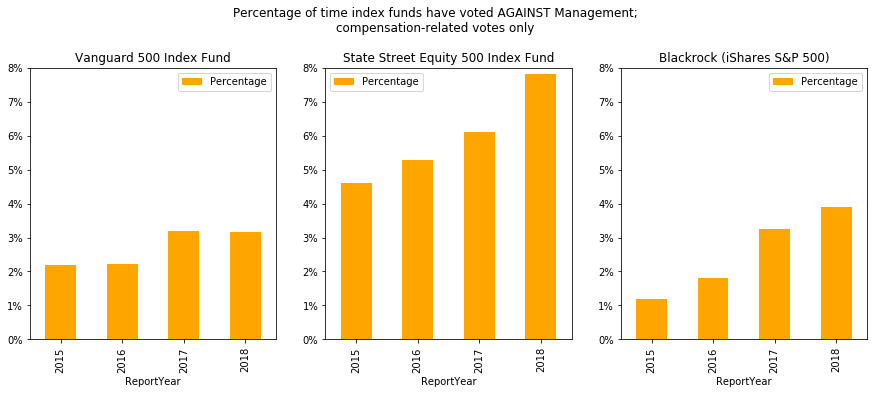

Raw data:


In [46]:
pt = ps[ps['Comp related']]
pt = pt.groupby(by=['Agree','VoteCast','ReportYear','Fund']).size().reset_index(name='Count').sort_values('Count', ascending=False)
pt = pt.groupby(by=['Agree','ReportYear','Fund']).agg({'Count':sum}).reset_index()
pt['Percentage'] = pt.groupby(by=['ReportYear','Fund'])['Count'].transform(lambda x:x/sum(x))
pt = pt[pt['Agree']==False].drop('Agree', axis=1)
pt = pt[pt['ReportYear']>=2015]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
pt[pt['Fund']=='Vanguard'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0,0.08), kind='bar',
                                title='Vanguard 500 Index Fund',
                                ax=axes[0],
                                color='orange')
pt[pt['Fund']=='State Street'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0,0.08), kind='bar',
                                title='State Street Equity 500 Index Fund',
                                ax=axes[1],
                                color='orange')
pt[pt['Fund']=='Blackrock'].plot(x='ReportYear', y=['Percentage'],
                                ylim=(0,0.08), kind='bar',
                                title='Blackrock (iShares S&P 500)',
                                ax=axes[2],
                                color='orange')
fig.suptitle('Percentage of time index funds have voted AGAINST Management;\ncompensation-related votes only',
            y=1.05)
for ax in axes:
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.show()
pt = pt.pivot_table(index='ReportYear', columns='Fund', values=['Count','Percentage'])
pt['Count'] = pt['Count'].astype('Int64')
print('Raw data:')
s = pt.mean()
s.name = 'Yearly average'
display(HTML(pt.append(s).to_html(formatters= 3*['{}'.format]+3*['{:,.1%}'.format])));

Two points worth mentioning:
1. The average disagreement on compensation sits around 5%. Blackrock and Vanguard in particular, only disagree on ~2.6% of the votes. As before, the implication is that the funds are happy with corporate compensation at US companies.
1. Fortunately, the trend has been moving towards more pushback on corporate compensation. This makes sense, in the context of current dissatisfaction with high income inequality, large corporate compensation and perceived disconnect between compensation and company performance.

## Conclusion

The data paints a picture of a world where:
1. Large passive mutual funds overwhelmingly vote the same way that management recommends
1. Corporate management holds disproportionately large votes on issues such as compensation
1. There is little pushback from passive asset managers when it comes to corporate compensation.